<a href="https://colab.research.google.com/github/ayulockin/Explore-NFNet/blob/main/Effect_of_BatchNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧰 Setups, Installations and Imports

In [2]:
%%capture
!pip install wandb

In [3]:
# deep learning imports
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import cifar10

# regular imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Seed everything for reproducibility
def seed_everything():
    # Set the random seeds
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
    np.random.seed(hash("improves reproducibility") % 2**32 - 1)
    tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

seed_everything()

# experiment tracking imports
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# ⛄ Download and Prepare Dataset

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

print('Shape of x_train: ', x_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of x_test: ', x_test.shape)
print('Shape of y_test: ', y_test.shape)

170500096/170498071 [==============================] - 6s 0us/step
Shape of x_train:  (50000, 32, 32, 3)
Shape of y_train:  (50000, 1)
Shape of x_test:  (10000, 32, 32, 3)
Shape of y_test:  (10000, 1)


# 🐾 Dataloader

In [19]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
IMG_SHAPE = 32
CHANNELS = 3
NUM_CLASSES = 10
EPOCHS = 100

In [10]:
@tf.function
def preprocess_image(image, label):
  image = tf.cast(image, tf.float32)
  image = image/255.0
  return image, label

In [11]:
trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

trainloader = (
    trainloader
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

(64, 32, 32, 3) (64, 1)


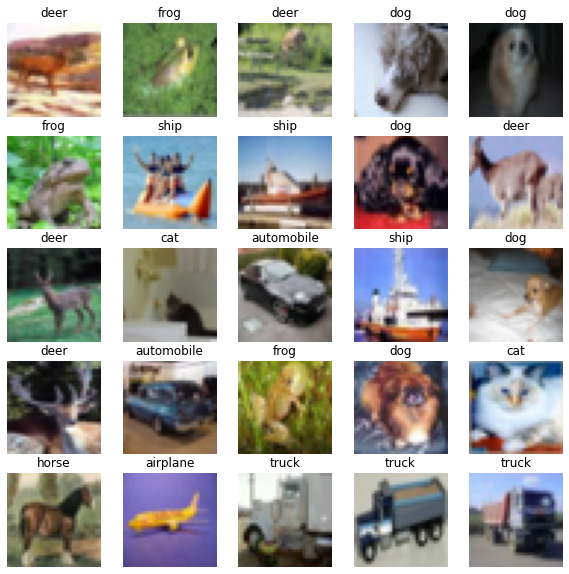

In [12]:
# Ref: https://www.tensorflow.org/tutorials/load_data/images
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[int(label_batch[n])])
      plt.axis('off')

image_batch, label_batch = next(iter(trainloader))
print(image_batch.shape, label_batch.shape)

show_batch(image_batch, label_batch)

# 📲 Callbacks

In [14]:
earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0, mode='auto',
    restore_best_weights=True
)

reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5,
    patience=3, verbose=1
)

# ☑️ Baseline

#### 🐤 Model - Without BN

In [16]:
def Model():
  inputs = keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, CHANNELS))

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(inputs)

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(x)

  x = keras.layers.MaxPooling2D(pool_size=2)(x)

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(x)

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(x)

  x = keras.layers.GlobalAveragePooling2D()(x)

  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  
  outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

  return keras.models.Model(inputs=inputs, outputs=outputs)

tf.keras.backend.clear_session()
model = Model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0     

## 🚋 Train with W&B

In [ ]:
tf.keras.backend.clear_session()
# Intialize model
model = Model()
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

# Intialize W&B run
run = wandb.init(entity='ayush-thakur', project='nfnet', job_type='bn-exploration')

# Train model
model.fit(trainloader,
          epochs=EPOCHS,
          validation_data=testloader,
          callbacks=[WandbCallback(),
                     reducelronplateau,
                     earlystopper])  

# Evaluate model on test set
loss, acc = model.evaluate(testloader)
wandb.log({'Test Accuracy': round(acc, 3)})

# Close W&B run
run.finish()

# 💰 Batch Normalization

#### 🐤 Model

In [23]:
def ModelBN():
  inputs = keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, CHANNELS))

  x = keras.layers.Conv2D(filters=32,
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid')(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.activations.relu(x)

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.activations.relu(x)

  x = keras.layers.MaxPooling2D(pool_size=2)(x)

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.activations.relu(x)

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.activations.relu(x)

  x = keras.layers.GlobalAveragePooling2D()(x)

  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  
  outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

  return keras.models.Model(inputs=inputs, outputs=outputs)

tf.keras.backend.clear_session()
model = ModelBN()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
tf.nn.relu_1 (TFOpLambda)    (None, 28, 28, 32)        0     

## 🚋 Train with W&B

In [24]:
tf.keras.backend.clear_session()
# Intialize model
model = ModelBN()
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

# Intialize W&B run
run = wandb.init(entity='ayush-thakur', project='nfnet', job_type='bn-exploration')

# Train model
model.fit(trainloader,
          epochs=EPOCHS,
          validation_data=testloader,
          callbacks=[WandbCallback(),
                     reducelronplateau,
                     earlystopper])  

# Evaluate model on test set
loss, acc = model.evaluate(testloader)
wandb.log({'Test Accuracy': round(acc, 3)})

# Close W&B run
run.finish()

Epoch 1/100
782/782 [==============================] - 14s 16ms/step - loss: 1.6522 - acc: 0.3867 - val_loss: 1.7069 - val_acc: 0.4272
Epoch 2/100
782/782 [==============================] - 12s 16ms/step - loss: 1.0795 - acc: 0.6127 - val_loss: 1.3745 - val_acc: 0.5268
Epoch 3/100
782/782 [==============================] - 13s 16ms/step - loss: 0.9445 - acc: 0.6627 - val_loss: 1.0337 - val_acc: 0.6320
Epoch 4/100
782/782 [==============================] - 12s 16ms/step - loss: 0.8601 - acc: 0.6950 - val_loss: 1.0660 - val_acc: 0.6283
Epoch 5/100
782/782 [==============================] - 13s 16ms/step - loss: 0.8043 - acc: 0.7176 - val_loss: 1.2691 - val_acc: 0.5767
Epoch 6/100
782/782 [==============================] - 12s 16ms/step - loss: 0.7567 - acc: 0.7343 - val_loss: 0.8680 - val_acc: 0.6966
Epoch 7/100
782/782 [==============================] - 13s 16ms/step - loss: 0.7194 - acc: 0.7442 - val_loss: 0.8689 - val_acc: 0.6969
Epoch 8/100
782/782 [==============================] - 

epoch,62
loss,0.39735
acc,0.86334
val_loss,0.61294
val_acc,0.7952
_runtime,801
_timestamp,1614947496
_step,63
best_val_loss,0.61217
best_epoch,52
Test Accuracy,0.796


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,▁▄▅▅▆▆▇▇▇▇▇▇▇███████████████████████████
val_loss,█▆▄▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▅▄▆▆▇▇▇▇█▇████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Test Accuracy,▁


![img](https://i.imgur.com/JExVQbq.png)